# Project - AllLife Credit Card Customer Segmentation

# **Background and Context:**

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

# **Objective:**

To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank. 

# **Key Questions:**

1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and service these customers?

# **Data Description:**

Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.

## Index

[1 - Define the Problem and Perform an Exploratory Data Analysis](#111)

[2 - Illustrate the Insights based on the EDA](#222)

[3 - Data Pre-processing](#333)

[4 - Applying K-means Clustering Algorithms](#444)

[5 - Applying Hierarchical Clustering](#555)

[6 - Compare K-means and Hierarchical Clustering, Perform Cluster Profiling and Derive Insights](#666)

[7 - Actionable Insights & Recommendations](#777)

#### Install Packages

In [ ]:
pip install --upgrade numpy

In [ ]:
pip install --upgrade pandas

In [ ]:
pip install --upgrade matplotlib

In [ ]:
pip install --upgrade seaborn

In [ ]:
pip install --upgrade sklearn

In [ ]:
pip install --upgrade scikit-plot

In [ ]:
pip install --upgrade yellowbrick

In [ ]:
pip install --upgrade openpyxl

In [ ]:
pip install --upgrade xlrd

#### Importing Libraries

In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np   
import pandas as pd    

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from sklearn.metrics import silhouette_score

from scipy.stats import zscore
from scipy.spatial.distance import pdist

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#### Creating Library of Functions

In [11]:
# Function used to Create a Combo Plot with a Boxplot and a Histogram

def histogram_boxplot(feature):
    sns.set({'figure.figsize': (12, 6)})
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.set_context("notebook")
    fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex = True, gridspec_kw = {"height_ratios": (.25, .75)})
    sns.boxplot(feature, showmeans = True, color='violet', ax = ax1)
    g = sns.histplot(feature, bins = 50, ax = ax2, kde = True)
    g.axvline(np.mean(feature), color = 'green', linestyle = '--') # Add mean to the histogram
    g.axvline(np.median(feature), color = 'black', linestyle = '-') # Add median to the histogram

In [12]:
# Countplots with Percentages (Univariate Analysis & Bivariate Analysis)

def perc_on_bar(feature):
    sns.set({'figure.figsize': (12, 6)})
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.set_context("notebook")
    total = len(feature)
    ax = sns.countplot(x = feature, data = data)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 2, '{:1.2f}'.format(100 * height / total) + "%", ha = "center");

In [13]:
# Function used to Create a Combo Plot with a Boxplot and a Histogram

def histogram_boxplot_perc_on_bar(feature):
    sns.set({'figure.figsize': (12, 8)})
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.set_context("notebook")
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, sharex = True, gridspec_kw = {"height_ratios": (.15, .30, .55)})
    sns.boxplot(feature, showmeans = True, color='violet', ax = ax1)
    g = sns.histplot(feature, bins = 50, ax = ax2, kde = True)
    g.axvline(np.mean(feature), color = 'green', linestyle = '--') # Add mean to the histogram
    g.axvline(np.median(feature), color = 'black', linestyle = '-') # Add median to the histogram
    total = len(feature)
    ax = sns.countplot(x = feature, data = data, ax = ax3)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 1, '{:1.2f}'.format(100 * height / total) + "%", ha = "center")
    plt.tight_layout();

In [14]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering
# citiblock distance = manhattan

def multiple_dendrograms(distance_metrics_general, linkage_methods_general, linkage_methods_eucledian):
    
    # Create a subplot image
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.set_context("notebook")
    n_rows = len(distance_metrics_general) * len(linkage_methods_general) + len(linkage_methods_eucledian)
    fig, axs = plt.subplots(n_rows, 1, figsize = (21, 5*n_rows))
    
    high_cophenet_corr = 0
    high_dm_lm = [0,0]
    compare = []
    counter = 0
    
    # General combinations between distnace metrics and linkage methods
    for dist_metr in distance_metrics_general:
        for link_method in linkage_methods_general:
            Z = linkage(data_std, metric = dist_metr, method = link_method)
            dendrogram(Z, ax = axs[counter])
            axs[counter].set_title('Dendrogram ({} Distance & {} Linkage Method)'.format(dist_metr.capitalize(), link_method.capitalize()))
            cophenetic_correlation, cophenetic_distances = cophenet(Z, pdist(data_std))
            axs[counter].annotate('Cophenetic Coefficient = {:.3f}'.format(cophenetic_correlation), (0.75, 0.90), xycoords = 'axes fraction')
            compare.append([dist_metr.capitalize(), link_method, cophenetic_correlation])
            counter = counter + 1
            if high_cophenet_corr < cophenetic_correlation:
                high_cophenet_corr = cophenetic_correlation
                high_dm_lm[0] = dist_metr
                high_dm_lm[1] = link_method
                
    # Linkage methods which only work with Euclidean distance
    for link_method in linkage_methods_eucledian:
        Z = linkage(data_std, metric = 'euclidean', method = link_method)
        dendrogram(Z, ax = axs[counter])
        axs[counter].set_title('Dendrogram (Eucledian Distance & {} Linkage Method)'.format(link_method.capitalize()))
        cophenetic_correlation, cophenetic_distances = cophenet(Z, pdist(data_std))
        axs[counter].annotate('Cophenetic Coefficient = {:.3f}'.format(cophenetic_correlation), (0.75, 0.9), xycoords = 'axes fraction')
        compare.append(['Euclidean', link_method.capitalize(), cophenetic_correlation])
        counter = counter + 1
        if high_cophenet_corr < cophenetic_correlation:
            high_cophenet_corr = cophenetic_correlation
            high_dm_lm[0] = dist_metr
            high_dm_lm[1] = link_method
    
    hierarchical_cluster_comparison = pd.DataFrame(compare, columns = ['Distance Metric', 'Linkage Method', 'Cophenetic Coefficient'])
    return hierarchical_cluster_comparison

***
## 1 - Define the Problem and Perform an Exploratory Data Analysis<a class="anchor" id="111"></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:blue;">

- Problem definition, questions to be answered 
- Data background and contents 
- Univariate analysis
- Bivariate analysis

### 1.1 - Problem definition, questions to be answered:

- Problem Statement & Background:\
Currently, following the advise from their Marketing Research Department, the Alllife Bank Operations Team is aware that the penetration in the market can be improved, and that their Customers perceive the support services of the back poorly. Based on this, the Operations Team wants to upgrade the bank Service Delivery Model, to ensure the Customers queries are resolved faster.

- Objective:\
To identify different segments based on existing Customer spending patterns as well as past interaction with the bank. Use the information extracted from these patterns to run personalised campaigns to target new Customers as well as upsell to existing Customers.

- Key Questions:\
How many different segments of customers are there?\
How are these segments different from each other?\
What are your recommendations to the bank on how to better market to and service these customers?

### 1.2 - Data Background and Contents

In [15]:
# Loading Dataset
data = pd.read_excel('Credit Card Customer Data.xlsx', sheet_name = 'Sheet1', header = 0, engine = 'openpyxl')

In [16]:
# Checking First 05 Rows
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [17]:
# Checking Data Shape
data.shape

(660, 7)

- There are total 07 columns and 660 rows in the dataset.

In [18]:
# Checking Data Types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


- The data type for all the columns is integer (int64).

In [19]:
# Checking Number of Missing Values per Variable
data.isnull().sum().sort_values(ascending = False)

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

- There aren't any missing values in the dataset.

In [20]:
# Check Unique Categories for each Variable
data.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

- 'Sl_No' is equivalent to a row ID and has unique values for each row in the dataset. This variable will be deleted since it wouldn't add value to the clustering analysis.
- 'Avg_Credit_Limit' is a Numeric/Continuous variable since there are several unique categories compared to the other variables.
- 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online' and 'Total_calls_made' are Numeric/Discrete variables with fewer categories.
- 'Customer Key' is probably related to Customer ID numbers, having almost all rows in the dataset with unique entries. 05 rows related to 'Customer Key' are repeated, meaning the same key/ID was used for more than one data entry in the dataset. In a real-world application, clustering doesn’t happen to static data, and it's a process that can be done several times to keep track not only about the different clusters but also on how Customers could be moving from one cluster to another. If the data was collected for a given timeframe and then repeated with a certain cadence (using same Customer keys), then a dynamic clusters analysis could be done. For a sake of this project, and following the instructions from the Academic Team this variable will be deleted from the dataset.

In [21]:
# Dropping 'Sl_No' and 'Customer Key' from the Dataset
data.drop(columns = ['Sl_No', 'Customer Key'], inplace = True)

In [22]:
data.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


- 'Sl_No' and 'Customer Key' variables were deleted from the dataset

In [23]:
# Check Uniques Categories Values per Variable
# Including Numeric/Discrete variables with less categories: 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online' and 'Total_calls_made'

discrete_cols = ['Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']

for column in discrete_cols :
    print(data[column].value_counts(normalize = False))
    print()
    print('-'*30)

4     151
6     117
7     101
5      74
2      64
1      59
3      53
10     19
8      11
9      11
Name: Total_Credit_Cards, dtype: int64

------------------------------
2    158
1    112
0    100
3    100
5     98
4     92
Name: Total_visits_bank, dtype: int64

------------------------------
2     189
0     144
1     109
4      69
5      54
3      44
15     10
7       7
8       6
10      6
12      6
11      5
13      5
9       4
6       1
14      1
Name: Total_visits_online, dtype: int64

------------------------------
4     108
0      97
2      91
1      90
3      83
6      39
7      35
9      32
8      30
5      29
10     26
Name: Total_calls_made, dtype: int64

------------------------------


- 'Total_Credit_Cards' is a Numerical/Discrete variable with 10 distinct categories ('1', '2', '3', '4', '5', '6', '7', '8', '9' and '10').
- 'Total_visits_bank' is a Numerical/Discrete variable with 06 distinct categories ('0', '1', '2', '3', '4' and '5').
- 'Total_visits_online' is a Numerical/Discrete variable with 16 distinct categories ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14' and '15').
- 'Total_calls_made' is a Numerical/Discrete variable with 11 distinct categories ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9 and '10').

### 1.3 - Univariate Analysis

##### Univariate Analysis for 'Credit_Limit'

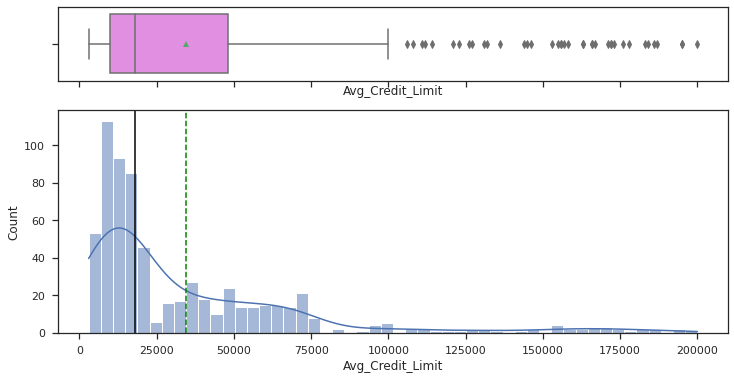

In [24]:
# Univariate Analysis for Numerical / Continuous Variable - Boxplot and Histogram for 'Credit_Limit'
histogram_boxplot(data['Avg_Credit_Limit'])

In [25]:
# Quantifying the number of outliers for 'Avg_Credit_Limit'
# The length of the upper whisker is the largest value in the dataset that is no greater than the third quartile plus 1.5 times the interquartile range.

Q1 = data['Avg_Credit_Limit'].quantile(0.25)
Q3 = data['Avg_Credit_Limit'].quantile(0.75)
IQR = Q3 - Q1
whisker_limit = Q3 + 1.5 * IQR
Upper_whisker = max(data['Avg_Credit_Limit'][(data['Avg_Credit_Limit'] < whisker_limit)])

In [26]:
print("There are {} data entries for 'Avg_Credit_Limit' above the Upper Whisker of {}, representing {}% of the total data entries"
      .format(len(data[(data['Avg_Credit_Limit'] > Upper_whisker)]), Upper_whisker, round(100 * len(data[(data['Avg_Credit_Limit']> Upper_whisker)]) / len(data), 2)))

There are 39 data entries for 'Avg_Credit_Limit' above the Upper Whisker of 100000, representing 5.91% of the total data entries


In [27]:
# Checking Descriptive Statistics and Skewness for 'Credit_Limit'
print(data[['Avg_Credit_Limit']].describe())
print()
print('Skewness', data[['Avg_Credit_Limit']].skew())

       Avg_Credit_Limit
count        660.000000
mean       34574.242424
std        37625.487804
min         3000.000000
25%        10000.000000
50%        18000.000000
75%        48000.000000
max       200000.000000

Skewness Avg_Credit_Limit    2.202396
dtype: float64


- 'Avg_Credit_Limit' has a range from \\$3000 to \\$200000, a mean and median at \\$34574.2 and \\$18000.0, respectively. Also, its distribution is skewed to the right (skewness of 2.20).
- There are 39 data entries for 'Avg_Credit_Limit' above the Upper Whisker of 100000, representing 5.91% of the total data entries. As per the boxplot rules, these 39 data entries for 'Avg_Credit_Limit' are considered outliers, and might show up as a separate cluster and cause other clusters to merge. Due to lack of additional information and domain expertize these outliers are decided to not be treated by using any imputation methods.
- Outliers will not only skew the mean but also the standard deviation. Even by doing the scaling, the effects of the outliers will still influence the results. The Manhatan distance (cityblock) is preferred when dealing with outliers which cannot be treated/removed. The Manhatan distance is calculated as a sum of unsigned lengths on each axis. Because it uses absolute values instead of exponentiation and rooting, it is said to be more robust to outliers. With that, at the hierarchical clustering analysis some additional emphasis will be given to the clustering methods utilizing the "cityblock" distance metric.

#### Univariate Analysis for 'Total_Credit_Cards'

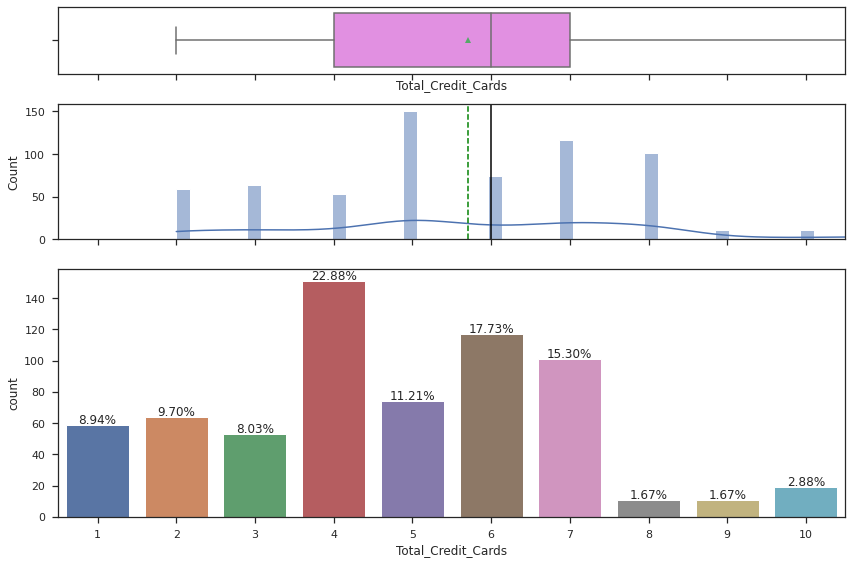

In [28]:
# Univariate Analysis for Numerical / Discrete variable - Boxplot, Histogram and Countplot with Percentages for 'Total_Credit_Cards'
histogram_boxplot_perc_on_bar(data['Total_Credit_Cards'])

- 'Total_Credit_Cards' of '4' is more frequent in the dataset, with 22.88% of contribution. 
- The 03 last categories on the right tail of the distribution ('8', '9' and '10') are less frequent than the other categories, with 1.67%, 1.67% and 2.88% of contribution, respectively.

#### Univariate Analysis for 'Total_visits_bank'

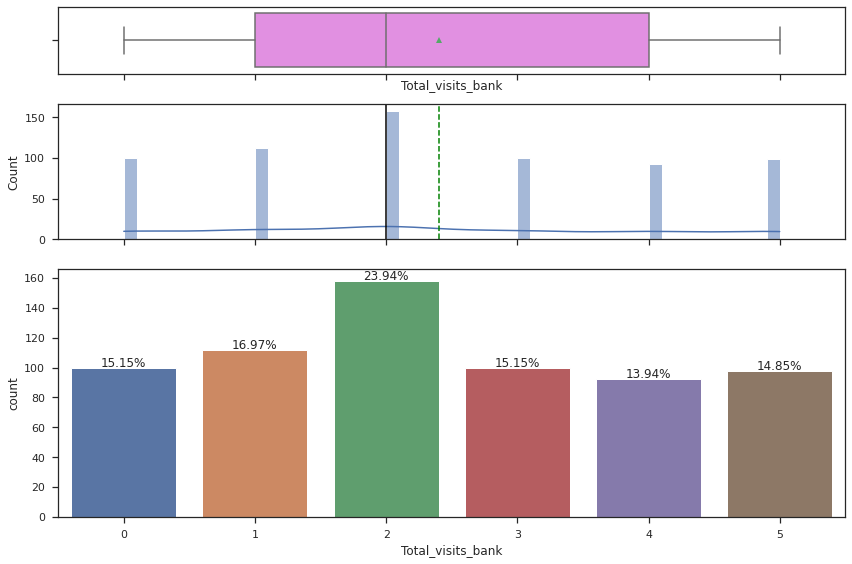

In [29]:
# Univariate Analysis for Numerical / Discrete variable - Boxplot, Histogram and Countplot with Percentages for 'Total_visits_bank'
histogram_boxplot_perc_on_bar(data['Total_visits_bank'])

- 'Total_visits_bank' of '2' is more frequent in the dataset, with 23.94% of contribution. The other categories are more levelled - with a range between 13.94%-16.97% in frequency.

#### Univariate Analysis for 'Total_visits_online'

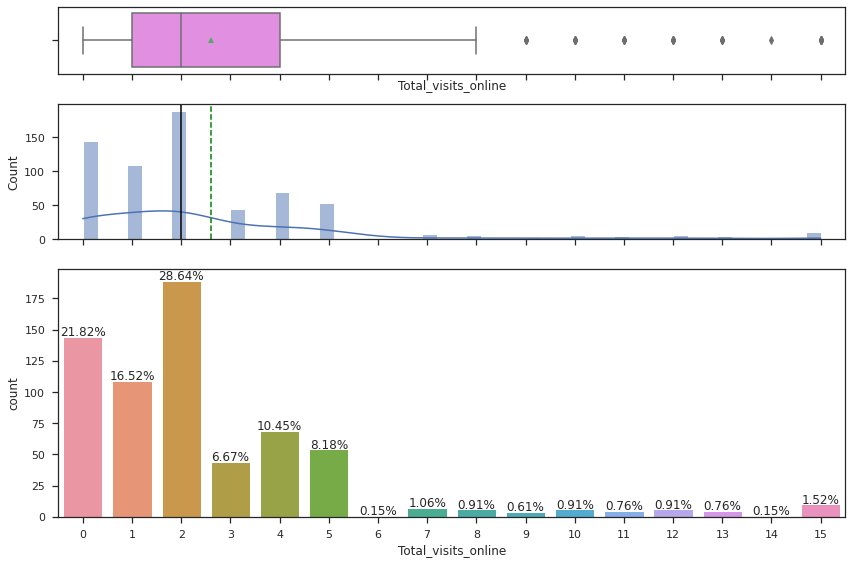

In [30]:
# Univariate Analysis for Numerical / Discrete variable - Boxplot, Histogram and Countplot with Percentages for 'Total_visits_online'
histogram_boxplot_perc_on_bar(data['Total_visits_online'])

In [31]:
# Quantifying the number of outliers for 'Total_visits_online'
# The length of the upper whisker is the largest value in the dataset that is no greater than the third quartile plus 1.5 times the interquartile range.

Q1 = data['Total_visits_online'].quantile(0.25)
Q3 = data['Total_visits_online'].quantile(0.75)
IQR = Q3 - Q1
whisker_limit = Q3 + 1.5 * IQR
Upper_whisker = max(data['Total_visits_online'][(data['Total_visits_online'] < whisker_limit)])

In [32]:
print("There are {} data entries for 'Total_visits_online' above the Upper Whisker of {}, representing {}% of the total data entries"
      .format(len(data[(data['Total_visits_online'] > Upper_whisker)]), Upper_whisker, round(100 * len(data[(data['Total_visits_online']> Upper_whisker)]) / len(data), 2)))

There are 37 data entries for 'Total_visits_online' above the Upper Whisker of 8, representing 5.61% of the total data entries


- The most frequent categories for 'Total_visits_online' are '0' (no online visits) and '2', with 21.82% and 28.64% of contribution, respectively.
- The 10 last categories on the right tail of the distribution are less frequent than the other categories, with a range between 0.15%-1.52%.
- There are 37 data entries for 'Total_visits_online' above the Upper Whisker of 8, representing 5.61% of the total data entries. As per the boxplot rules, these 37 data entries for 'Total_visits_online' are considered outliers, and might show up as a separate cluster and cause other clusters to merge. Due to lack of additional information and domain expertize these outliers are decided to not be treated by using any imputation methods.
- Outliers will not only skew the mean but also the standard deviation. Even by doing the scaling, the effects of the outliers will still influence the results. The Manhatan distance (cityblock) is preferred when dealing with outliers which cannot be treated/removed. The Manhatan distance is calculated as a sum of unsigned lengths on each axis. Because it uses absolute values instead of exponentiation and rooting, it is said to be more robust to outliers. With that, at the hierarchical clustering analysis some additional emphasis will be given to the clustering methods utilizing the "cityblock" distance metric.

#### Univariate Analysis for 'Total_calls_made'

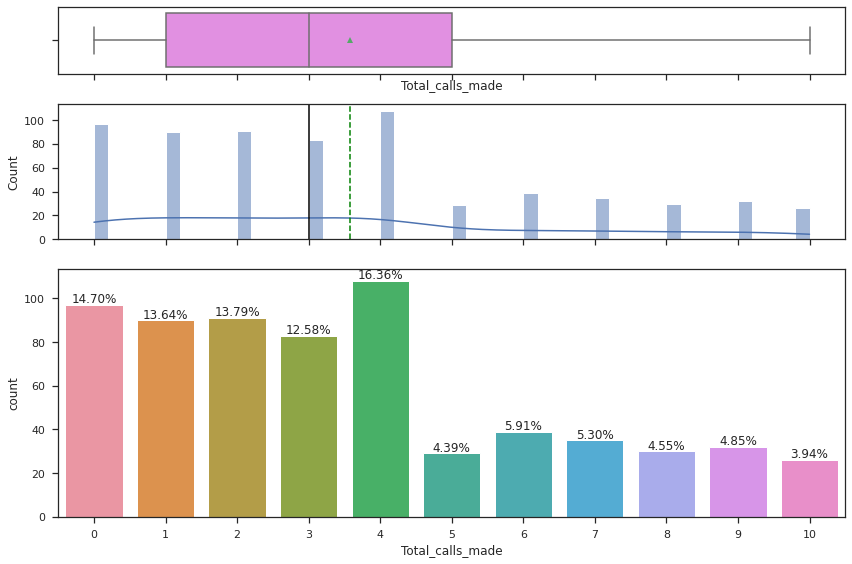

In [33]:
# Univariate Analysis for Numerical / Discrete variable - Boxplot, Histogram and Countplot with Percentages for 'Total_calls_made'
histogram_boxplot_perc_on_bar(data['Total_calls_made'])

- The most frequent categories for 'Total_visits_online' are '0' (no calls made), '1', '2', '3' and '4', varying from range between 12.58-16.36% of contribution.
- The 06 last categories on the right tail of the distribution are less frequent than the other categories, with a range between 3.94%-5.91%.

### 1.4 - Bivariate Analysis

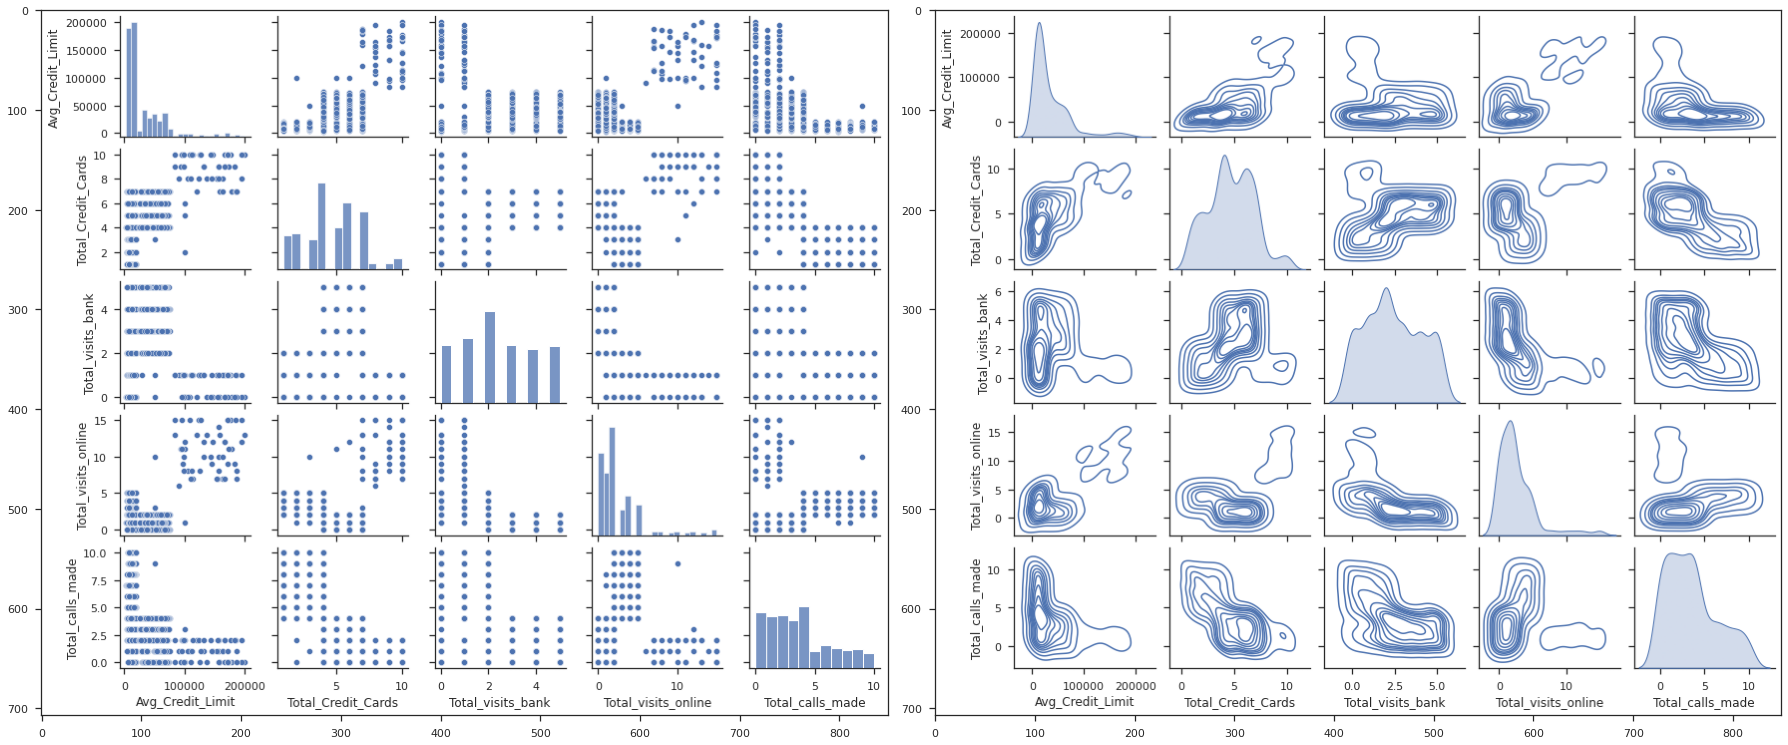

In [34]:
# Bivariate Analysis - Pairplot for Numeric/Continuous and Numerical/Discrete Variables
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")
g0 = sns.pairplot(data = data, height = 2, aspect = 1.2)
g0.savefig('g0.png')
plt.close(g0.fig)
g1 = sns.pairplot(data = data, kind = "kde", diag_kind = "kde", height = 2, aspect = 1.2)
g1.savefig('g1.png')
plt.close(g1.fig)

f, axarr = plt.subplots(1, 2, figsize = (25, 20))
axarr[0].imshow(mpimg.imread('g0.png'))
axarr[1].imshow(mpimg.imread('g1.png'))
plt.tight_layout();

- Looking at the Pairplot above, specifically at the 'kde' plots on the right, the variable which apparently has more distinct clusters is the "Total_Credit_Cards". By comparing the pair-wise kernel densities between "Total_Credit_Cards" and the other variables, this might suggest at least 03 clusters are needed to capture these pair-wise differences in the dataset.

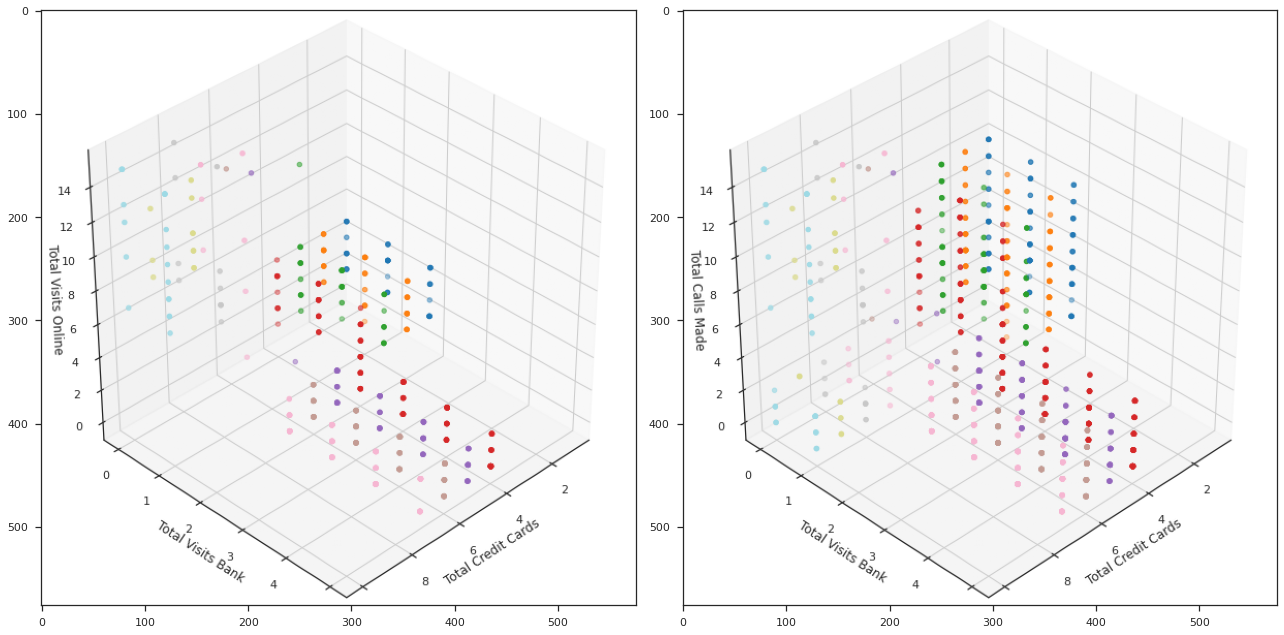

In [35]:
# 3D Scatterplot with the "Total_Credit_Cards" on the x-axis, the "Total_visits_bank" on the y-axis
# Varying the z-axis with both "Total_visits_online" (scatterplot on the left) and "Total_calls_made" (scatterplot on the right) 

sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")
figure = plt.figure(figsize = (8, 8))
ax = Axes3D(figure, azim = 45, elev = 35, box_aspect = (0.75, 0.75, 0.75))

x = data['Total_Credit_Cards']
y = data['Total_visits_bank']
z = data['Total_visits_online']
z1 = data['Total_calls_made']

ax.scatter(xs = x, ys = y, zs = z, c = x, cmap = 'tab20')
ax.set_xlabel('Total Credit Cards')
ax.set_ylabel('Total Visits Bank')
ax.set_zlabel('Total Visits Online')
ax.figure.savefig('g0.png')

ax.scatter(xs = x, ys = y, zs = z1, c = x, cmap = 'tab20')
ax.set_xlabel('Total Credit Cards')
ax.set_ylabel('Total Visits Bank')
ax.set_zlabel('Total Calls Made')
ax.figure.savefig('g1.png')
plt.close()

f, axarr = plt.subplots(1, 2, figsize = (18, 20))
axarr[0].imshow(mpimg.imread('g0.png'))
axarr[1].imshow(mpimg.imread('g1.png'))
plt.tight_layout();

- Looking at the 3D Scatterplots above, with the "Total_Credit_Cards" on the x-axis, the "Total_visits_bank" on the y-axis and varying the z-axis with both "Total_visits_online" (scatterplot on the left) and "Total_calls_made" (scatterplot on the right) it's more evident we may have 03 distinct clusters.

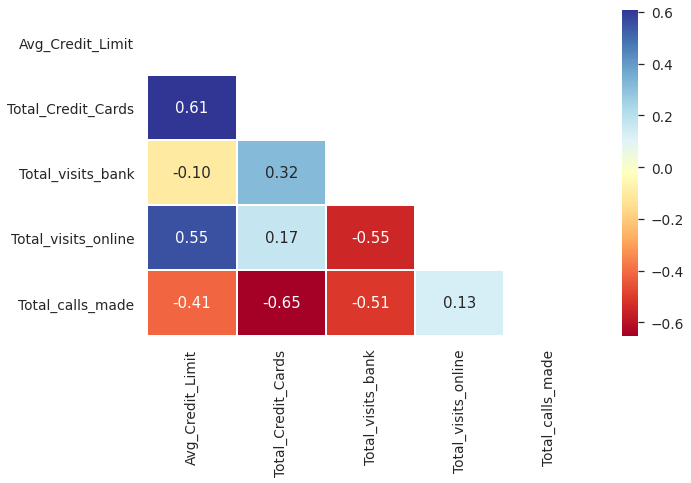

In [36]:
# Bivariate Analysis - Heatmap for Numeric/Continuous and Numerical/Discrete Variables
sns.set({'figure.figsize': (10, 6)})
sns.set_style("whitegrid")
corr = data.corr()
lower_triangle = np.tril(corr, k = -1)
sns.set_context("notebook", font_scale = 1.25)
mask = lower_triangle == 0
sns.heatmap(data.corr(), annot = True, cmap = "RdYlBu", fmt = '.2f', linewidths = 0.05, mask = mask);

- "Avg_Credit_Limit" and "Total_Credit_Cards" have a relevant positive correlation (61%), meaning the Customers who have more credit cards are also more likely to have a higher average credit card limit.
- "Avg_Credit_Limit" and "Total_visits_online" have a relevant positive correlation (55%), meaning the Customers who have higher credit limits are more inclined to make more online visits.
- "Total_Credit_Cards" and "Total_calls_made" have a relevant negative correlation (-65%), meaning the Customers who have more credit cards are less likely to make calls to be bank.
- "Total_visits_bank" and "Total_visits_online" have a relevant negative correlation (-55%), meaning the Customers who make more frequent online visits are less inclined to physically go to the bank for a visit.

***
## 2 - Illustrate the Insights based on EDA <a class="anchor" id="222"></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:blue;">
- Key meaningful observations on the relationship between variables

Summary for the key insights from EDA (all graphs and other details were covered at the previous sessions): 

- There are total 07 columns and 660 rows in the dataset. The data type for all the columns is integer (int64). There aren't any missing values in the dataset.

- The variable 'Sl_No' was deleted from the dataset, since it's equivalent to a row ID and has unique values for each row in the dataset. There are 05 repeated rows for 'Customer Key' meaning the same key/ID was used for more than one data entry in the dataset. In a real-world application, clustering doesn’t happen to static data, and it's a process that can be done several times to keep track not only about the different clusters but also on how Customers could be moving from one cluster to another. If the data was collected for a given timeframe and then repeated with a certain cadence (using same Customer keys), then a dynamic clusters analysis could be done. For a sake of this project, and following the instructions from the Academic Team this variable was be deleted from the dataset.

- 'Avg_Credit_Limit' is a Numeric/Continuous variable since there are several unique categories compared to the other variables.

- 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online' and 'Total_calls_made' are Numeric/Discrete variables with 10, 6, 16 and 11 distinct categories, respectively.

- 'Avg_Credit_Limit' has a range from \\$3000 to \\$200000, a mean and median at \\$34574.2 and \\$18000.0, respectively. Also, its distribution is skewed to the right (skewness of 2.20). There are 39 data entries for 'Avg_Credit_Limit' above the Upper Whisker of 100000, representing 5.91% of the total data entries.

- 'Total_Credit_Cards' of '4' is more frequent in the dataset, with 22.88% of contribution. The 03 last categories on the right tail of the distribution ('8', '9' and '10') are less frequent than the other categories, with 1.67%, 1.67% and 2.88% of cobtribution, respectively.

- 'Total_visits_bank' of '2' is more frequent in the dataset, with 23.94% of contribution. The other categories are more levelled - with a range between 13.94%-16.97% in frequency.

- The most frequent categories for 'Total_visits_online' are '0' (no online visits) and '2', with 21.82% and 28.64% of contribution, respectively. The 10 last categories on the right tail of the distribution are less frequent than the other categories, with a range between 0.15%-1.52%. There are 37 data entries for 'Total_visits_online' above the Upper Whisker of 8, representing 5.61% of the total data entries.

- The most frequent categories for 'Total_visits_online' are '0' (no calls made), '1', '2', '3' and '4', varying from range between 12.58-16.36% of contribution. The 06 last categories on the right tail of the distribution are less frequent than the other categories, with a range between 3.94%-5.91%.

- At the bivariate analysis (Pairplot), the variable which apparently has more distinct clusters is the "Total_Credit_Cards". By comparing the pair-wise kernel densities between "Total_Credit_Cards" and the other variables, this might suggest at least 03 clusters are needed to capture these pair-wise differences in the dataset. Looking at the 3D Scatterplots with the "Total_Credit_Cards" on the x-axis, the "Total_visits_bank" on the y-axis and varying the z-axis with both "Total_visits_online" and "Total_calls_made" it's more evident we may have 03 distinct clusters.

- At the bivariate analysis (Heatmap), "Avg_Credit_Limit" and "Total_Credit_Cards" have a relevant positive correlation (61%), meaning the Customers who have more credit cards are also more likely to have a higher average credit card limit. "Avg_Credit_Limit" and "Total_visits_online" have a relevant positive correlation (55%), meaning the Customers who have higher credit limits are more inclined to make more online visits. "Total_Credit_Cards" and "Total_calls_made" have a relevant negative correlation (-65%), meaning the Customers who have more credit cards are less likely to make calls to be bank. "Total_visits_bank" and "Total_visits_online" have a relevant negative correlation (-55%), meaning the Customers who make more frequent online visits are less inclined to physically go to the bank for a visit.

-  As per the boxplot rules, around 6% of the data entries for both 'Avg_Credit_Limit' and 'Total_visits_online' are considered to be outliers, and might show up as a separate cluster and cause other clusters to merge. Due to lack of additional information and domain expertize these outliers are decided to not be treated by using any imputation methods. Outliers will not only skew the mean but also the standard deviation. Even by doing the scaling, the effects of the outliers will still influence the results. The Manhatan distance (cityblock) is preferred when dealing with outliers which cannot be treated/removed. The Manhatan distance is calculated as a sum of unsigned lengths on each axis. Because it uses absolute values instead of exponentiation and rooting, it is said to be more robust to outliers. With that, at the hierarchical clustering analysis some additional emphasis will be given to the clustering methods utilizing the "cityblock" distance metric.

***
## 3. Data Pre-processing <a class="anchor" id="333"></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:blue;">
    
- Prepare the data for analysis
- Feature Engineering
- Missing value Treatment
- Outlier Treatment
- Duplicate observations check and removal if found

### 3.1 - Duplicate Observations

In [37]:
# Looking ta duplicates in the dataset
data.duplicated().sum()

11

In [38]:
data[data.duplicated()]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
162,8000,2,0,3,4
175,6000,1,0,2,5
215,8000,4,0,4,7
295,10000,6,4,2,3
324,9000,4,5,0,4
361,18000,6,3,1,4
378,12000,6,5,2,1
385,8000,7,4,2,0
395,5000,4,5,0,1
455,47000,6,2,0,4


- There are 11 duplicate rows in the dataset for the features on interest, however these rows are associated with different Customer IDs ("Sl_No" and "Customer Key"). 
- For clustering analysis it's not recommended to eliminate data duplicates since they are particularly likely combinations of variable values, which should get a higher weight because of that. This means observations with the same values do not become redundant.
- Based on these observation, these duplicates won't be removed from the dataset.

### 3.2 - Prepare Data for Analysis - Standardization

In [39]:
# Standardization using "scipy.stats import zscore"
data_std = data.apply(zscore)

In [40]:
data_std.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


- Since the variables of interest have different scales/dimensions, the dataset was standardized using z-scores before proceeding with any clustering methods.

***
## 4. Applying K-means Clustering Algorithms <a class="anchor" id="444"></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:blue;">
    
- Apply K-means
- Elbow Curve
- Silhouette Score
- Figure out Appropriate Number of Clusters

### 4.1 - Apply K-means and Elbow Curve

In [41]:
# Instantiating the clustering model and visualizer
model = KMeans(random_state = 4)

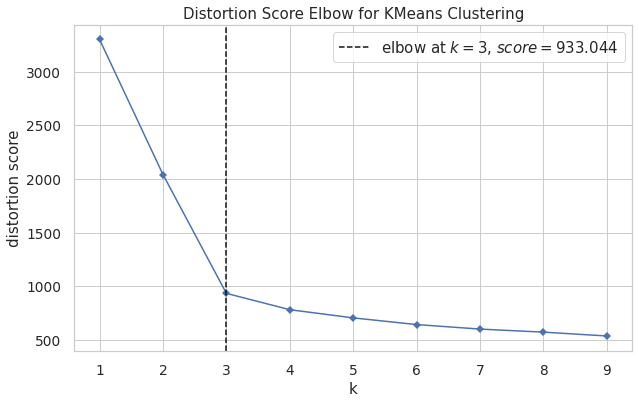

In [42]:
# Using the "KElbowVisualizer" from the "yellowbrick" library to create the Elbow Curve (metric = 'distortion')

visualizer = KElbowVisualizer(model, k = (1, 10), locate_elbow = True, metric = 'distortion', timings = False)
visualizer.fit(data_std)
visualizer.show();

- The appropriate number of clusters (k) seem to be at 03, where the "elbow" cn be visualized on the plot above.

### 4.2 - Silhouette Score for K-means

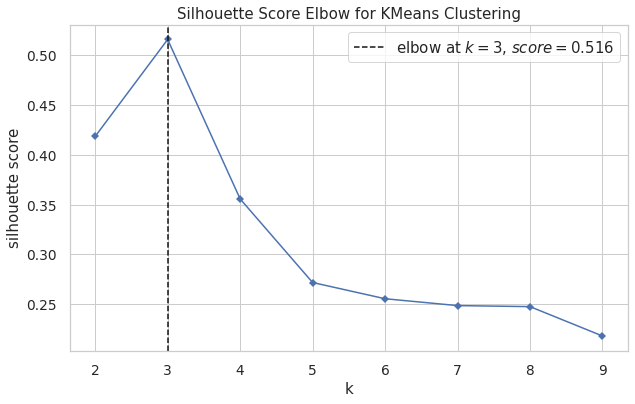

In [43]:
# Using the "KElbowVisualizer" from the "yellowbrick" library to create the Silhouette Scores for multiple number of clusters (metric = 'silhouette')
# Calculating the Silhouette Coefficients for multiple number of clusters (k).
# The Silhouette Score is used to evaluate the density and separation between clusters
# The Silhouette Coefficient is computed by averaging the silhouette coefficient for each sample.
# This is calculated as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. 

visualizer = KElbowVisualizer(model, k = (2, 10), locate_elbow = True, metric = 'silhouette', timings = False)
visualizer.fit(data_std)
visualizer.show();

- Silhouette Score can be between 1 and -1, where 1 is highly dense clusters and -1 is completely incorrect clustering. Values near 0 indicate overlapping clusters. 
- On the plot above, k = 3 (03 clusters) is associated with the highest Silhouette Score, meaning that 03 clusters represents the best choice.

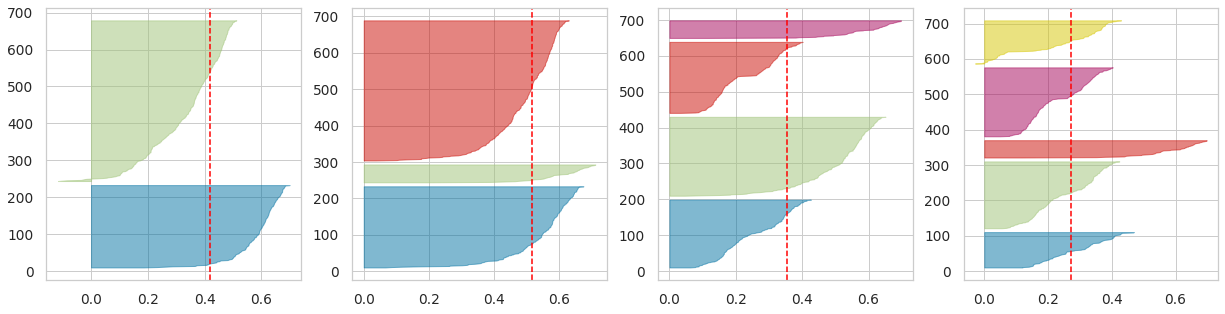

In [44]:
# Finding optimal no. of clusters with silhouette coefficients
# Silhouette Visualizer from Yellowbrick Package
fig, ax = plt.subplots(1, 4, figsize = (21, 5))
for i in [2, 3, 4, 5]:
    km = KMeans(n_clusters = i, random_state = 4)
    visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax = ax[i-2])
    visualizer.fit(data_std);

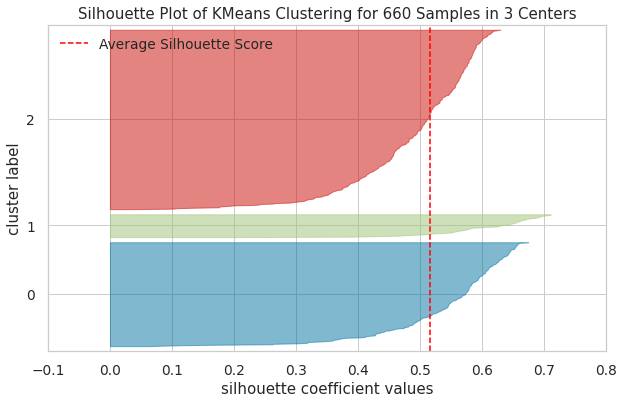

In [45]:
# SiLhouette Plot for 03 clusters 
visualizer = SilhouetteVisualizer(KMeans(3, random_state = 4), colors = 'yellowbrick')
visualizer.fit(data_std)
visualizer.show();

- Comparing all the Silhouette plots above, the option for 03 clusters (2nd plot from left to right) looks to be the best choice since the Silhouette Score for each cluster is above the average (red dash line), and the fluctuation in size (width) looks similar.
- One remark here is that the thickness of the Silhouette Plot representing each cluster should also be taken into account as a deciding point. The more uniform the thickness, the more optimal the number of clusters is. In this case neither of the 04 options above present uniform thickness across all clusters. With that, and looking at all other aspects, the option for 03 clusters is still deemed to be the best choice among the others.

### 4.3 - Initial Insights about Customer Segmentation using K-Means Clustering

In [46]:
# Creating the final model with 03 clusters
final_model = KMeans(n_clusters = 3, random_state = 4)
final_model.fit(data_std)
prediction = final_model.predict(data_std)

In [47]:
# Appending the respective centroid-based clusters (K-means Cluster) for each data row to the original dataset 
data['K-means Cluster'] = prediction
data.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K-means Cluster
0,100000,2,1,1,0,2
1,50000,3,0,10,9,0
2,50000,7,1,3,4,2
3,30000,5,1,1,4,2
4,100000,6,0,12,3,1
5,20000,3,0,1,8,0
6,100000,5,0,11,2,1
7,15000,3,0,1,1,0
8,5000,2,0,2,2,0
9,3000,4,0,1,7,0


In [48]:
# Creating insights about the Customer profile by grouping the original dataset by cluster
# Adding the counts and percentages for each segment in the grouped data table

cluster_profile_Kmeans = data.groupby('K-means Cluster').mean()
cluster_profile_Kmeans['Number of Entries in each Segment'] = data.groupby('K-means Cluster')['Avg_Credit_Limit'].count()
cluster_profile_Kmeans['% in each Segment'] = round(100 * data.groupby('K-means Cluster')['Avg_Credit_Limit'].count() / len(data), 1).astype(str) + '%'

In [49]:
# Displaying Cluster profile
cluster_profile_Kmeans.style.highlight_min(color = 'red', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Number of Entries in each Segment,% in each Segment
K-means Cluster,,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224,33.9%
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50,7.6%
2,33782.383420,5.515544,3.489637,0.981865,2.000000,386,58.5%


- Looking at the table above, the first cluster (K-means Cluster = 0) represents around 34% of the data entries and takes the Customers with the lowest "Avg_Credit_Limit" and "Total_Credit_Cards", but with the highest "Total_calls_made".
- The second cluster (K-means Cluster = 1) represents around 8% of the data entries and takes the Customers with higher "Avg_Credit_Limit", "Total_Credit_Cards" and "Total_visits_online". It also encompasses the Customers who are not likely to go to the bank (lowest "Total_visits_bank"), and also less inclined to make calls to the bank (lowest "Total_calls_made").
- The third cluster (K-means Cluster = 2) represents around 58% of the data entries and is related to Customers who normally go to the bank (highest "Total_visits_bank"), and are not likely to use the online bank services (lowest "Total_visits_online").

***
## 5. Applying Hierarchical Clustering <a class="anchor" id="555"></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:blue;">
    
- Apply Hierarchical Clustering with Different Linkage Methods
- Plot Dendrograms for each Linkage Method
- Choose Appropriate Number of Clusters

### 5.1 - Apply Hierarchical Clustering with Different Distance Metrics and Linkage Methods & Plot all Dendrograms

,Distance Metric,Linkage Method,Cophenetic Coefficient
0,Euclidean,single,0.739122
1,Euclidean,complete,0.859973
2,Euclidean,average,0.897708
3,Euclidean,weighted,0.886175
4,Chebyshev,single,0.738235
5,Chebyshev,complete,0.853347
6,Chebyshev,average,0.897416
7,Chebyshev,weighted,0.891362
8,Mahalanobis,single,0.705806
9,Mahalanobis,complete,0.542279


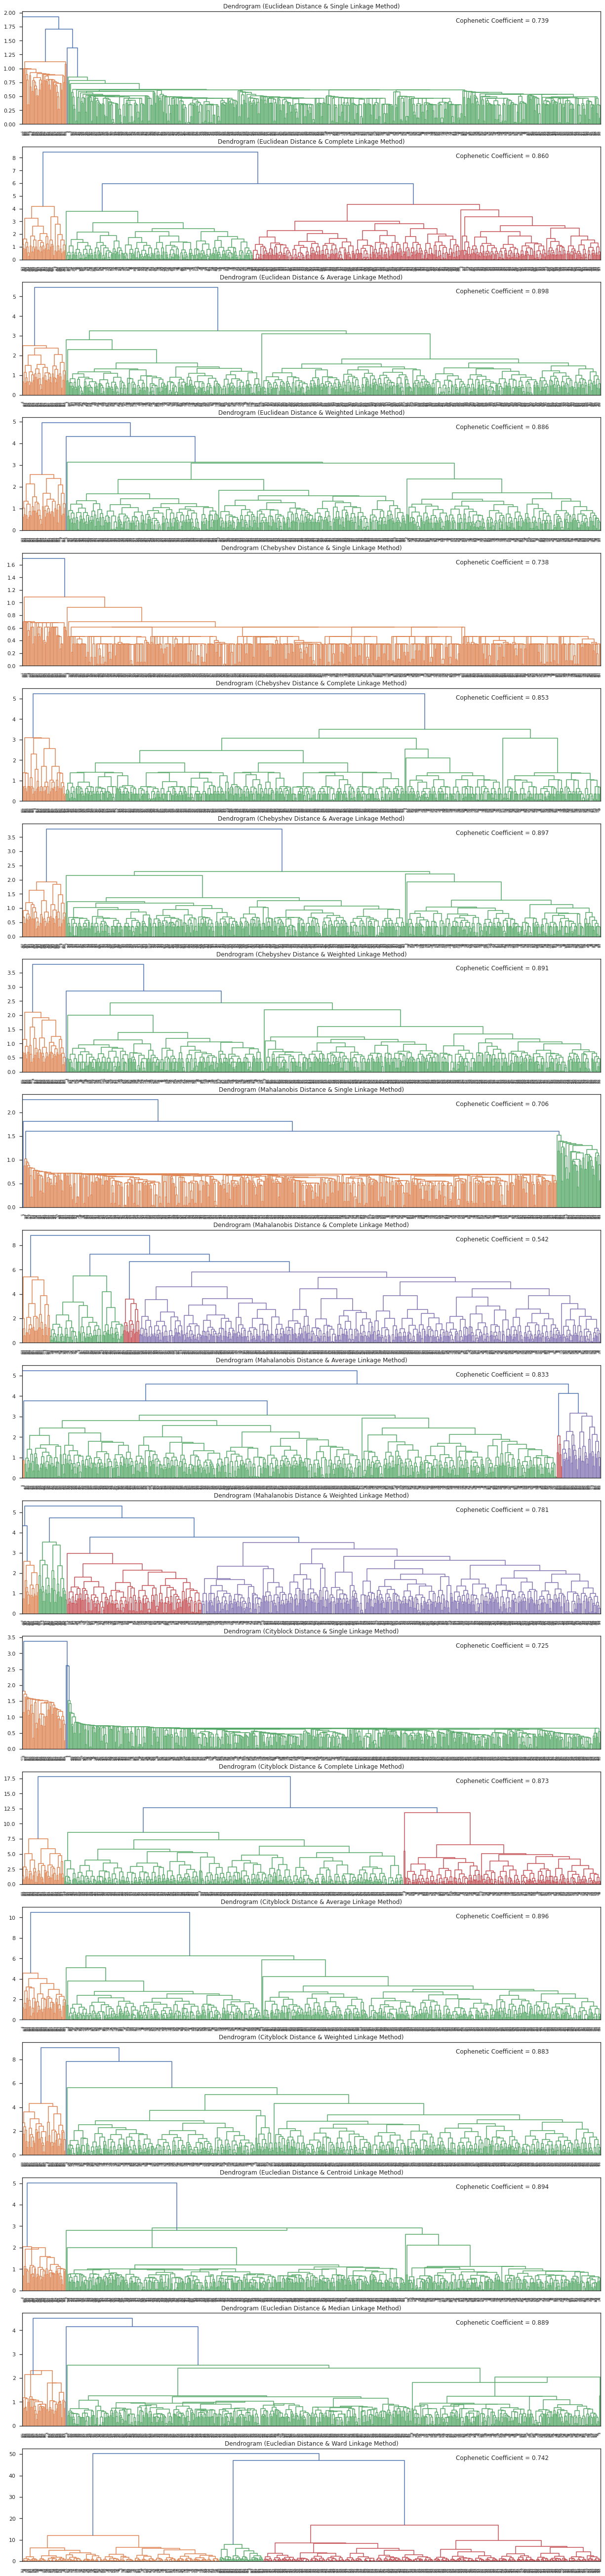

In [50]:
# Utilizing the previously created "multiple_dendrograms" def function to create dendrograms for multiple distances and multiple linkage methods.
# 'centroid', 'median' and 'ward' linkage methods only work with Euclidean distances - that's the reason why there's a separate list called "linkage_methods_eucledian" for them.
# The first output of this def function is a dataframe with the Cophenetic Coefficients for all the combinations associated with the assigned distance metrics and linkage methods.
# Following that, all the possible combinations for dendrograms will be displayed for every variant of distance metric and linkage method.
# The multiple displayed dendrograms will be analyzed to decide which one is the best option regarding its capability of identifying the most distinct clusters.

multiple_dendrograms(distance_metrics_general = ['euclidean', 'chebyshev', 'mahalanobis', 'cityblock'],
                     linkage_methods_general = ['single', 'complete', 'average', 'weighted'],
                     linkage_methods_eucledian = ['centroid', 'median', 'ward'])

- At the EDA session (Bivariate analysis - Pairplot and 3D Scatterplot) the ideal minimum number of clusters seemed to be around 03. Also, at the Centroid-based clustering analysis (K-means) session, it was concluded the optimal number of clusters was 03 as well. With that, when looking at the dendrograms above, the main focus was to identify the options capable to differentiate the 03 most distinct clusters.
- The dendrograms which were able to differentiate the 03 most distinct clusters were:
    - Eucliden Distance Metric & Complete Linkage (Cophenetic Correlation = 0.877)
    - Cityblock (Manhatan) Distance Metric & Complete Linkage (Cophenetic Correlation = 0.875)
    - Eucliden Distance Metric & Ward Linkage (Cophenetic Correlation = 0.741)

### 5.2 - Choose Appropriate Number of Clusters (Distance Metric & Linkage Method)

,Distance Metric,Linkage Method,Cophenetic Coefficient
0,Euclidean,complete,0.859973
1,Cityblock,complete,0.873148
2,Euclidean,Ward,0.741516


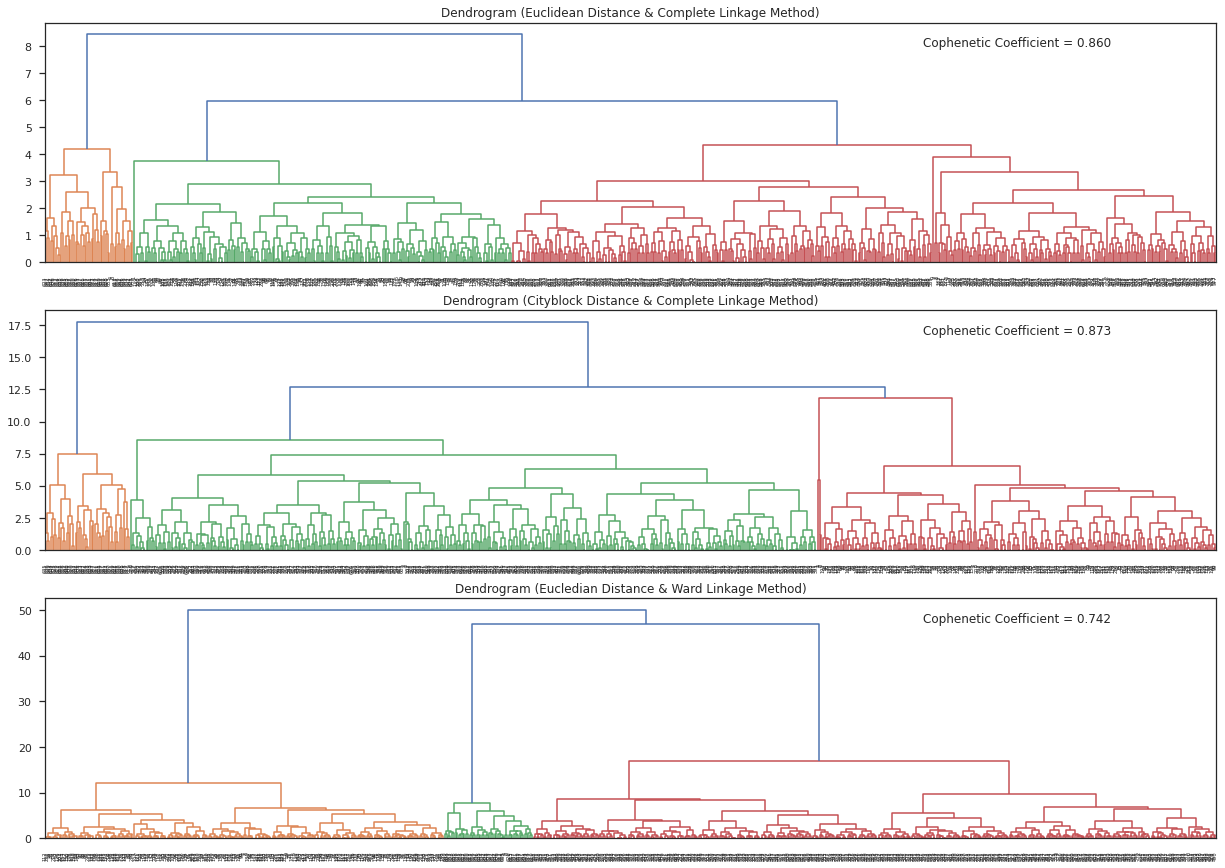

In [51]:
# Utilizing the previously created "multiple_dendrograms" def function to create the dendrograms with the 03 most distinct clusters.
# The firt output of this def function is a dataframe with the Cophenetic Coefficients for all the combinations associated with the assigned distance metrics and linkage methods.
# More than one dendrogram is able to identify distinct clusters. Some additional analysis (Cophenetic Correlation and Silhouette Score) will be used to drive the best choice. 
# Also, because of the presence of outliers in the dataset, the cluster with the "cityblock" distance will have an extra weight in the choice for the best clustering option.

multiple_dendrograms(distance_metrics_general = ['euclidean', 'cityblock'],
                     linkage_methods_general = ['complete'],
                     linkage_methods_eucledian = ['ward'])

In [52]:
# Calculating the Silhouette Scores for multiple number of clusters on the 03 clustering options previously identified.
# The Silhouette Score is used to evaluate the density and separation between clusters
# The Silhouette Coefficient is computed by averaging the silhouette coefficient for each sample.
# This is calculated as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. 

distance_metrics_general = ['euclidean', 'cityblock']
linkage_methods_general = ['complete']
linkage_methods_euclidean = [ 'ward']
clusters = 10

sil_score = []
cluster_list = list(range(2, clusters + 1))
       
# General combinations between distance metrics and linkage methods
for dist_metr in distance_metrics_general:
    for link_method in linkage_methods_general:
        for n_clusters in cluster_list:
            clusterer = AgglomerativeClustering(n_clusters = n_clusters, affinity = dist_metr, linkage = link_method)
            preds = clusterer.fit_predict(data_std)
            score = silhouette_score(data_std, preds)
            sil_score.append([dist_metr.capitalize(), link_method.capitalize(), n_clusters, score])

# Linkage methods which only work with Euclidean distance
for link_method in linkage_methods_euclidean:
    for n_clusters in cluster_list:
        clusterer = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage = link_method)
        preds = clusterer.fit_predict(data_std)
        score = silhouette_score(data_std, preds)
        sil_score.append(['Euclidean', link_method.capitalize(), n_clusters, score])
        
silhouette_comparison = pd.DataFrame(sil_score, columns = ['Distance Metric', 'Linkage Method', 'Number of Clusters', 'Silhouette Score'])
silhouette_comparison['Distance & Linkage'] = silhouette_comparison['Distance Metric'] + ' ' + silhouette_comparison['Linkage Method']

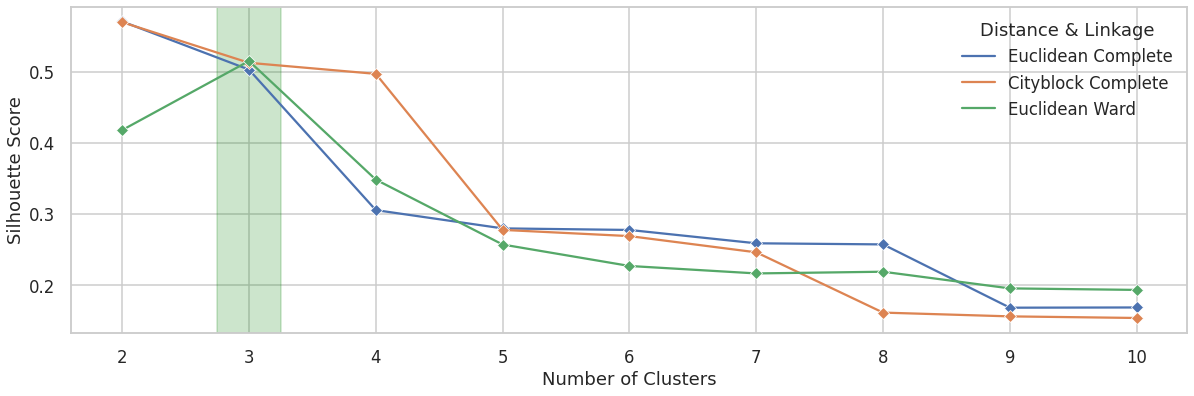

In [53]:
# Lineplot for the Silhouette Scores for multiple number of clusters on the 03 clustering options previously identified.
sns.set({'figure.figsize': (20,6)})
sns.set_style("whitegrid")
sns.set_context("talk")
g = sns.lineplot(x = "Number of Clusters", y = "Silhouette Score", hue = "Distance & Linkage", marker = 'D', data = silhouette_comparison)
g.axvspan(2.75, 3.25, color = 'green', alpha = 0.2);

- All the 03 clustering options explored above were able to identify 03 distinct clusters and had similar Silhouette Scores for 03 clusters.
- The utilized criteria to select the best clustering option was based on the capability to discriminate 03 distinct clusters, Cophenetic Correlation and Robustness to Outliers:
    - Eucliden Distance Metric & Complete Linkage:
        > Capability to discriminate 03 distinct clusters (++)\
        > Cophenetic Correlation = 0.860 (+++)\
        > Robustness to Outliers (-)
    - Cityblock (Manhatan) Distance Metric & Complete Linkage
        > Capability to discriminate 03 distinct clusters (+)\
        > Cophenetic Correlation = 0.873 (+++)\
        > Robustness to Outliers (+)
    - Eucliden Distance Metric & Ward Linkage
        > Capability to discriminate 03 distinct clusters (+++)\
        > Cophenetic Correlation = 0.742 (+)\
        > Robustness to Outliers (-)

- Based on the criteria above, Cityblock (Manhatan) Distance Metric & Complete Linkage was selected as the best clustering option since it was able to discriminate the 03 distinct clusters, had a such a high Cophenetic Correlation, and was also based on Manhatan (citiblock) distances which are inherently more robust to outliers.

### 5.3 - Hierarchical Clustering Final Dendrogram Option & Initial Insights about Customer Segmentation using Hierarchical Clustering

In [54]:
# Generating the Linkage Matrix for the best selected clustering option
Z = linkage(data_std, method = 'complete', metric = 'cityblock')

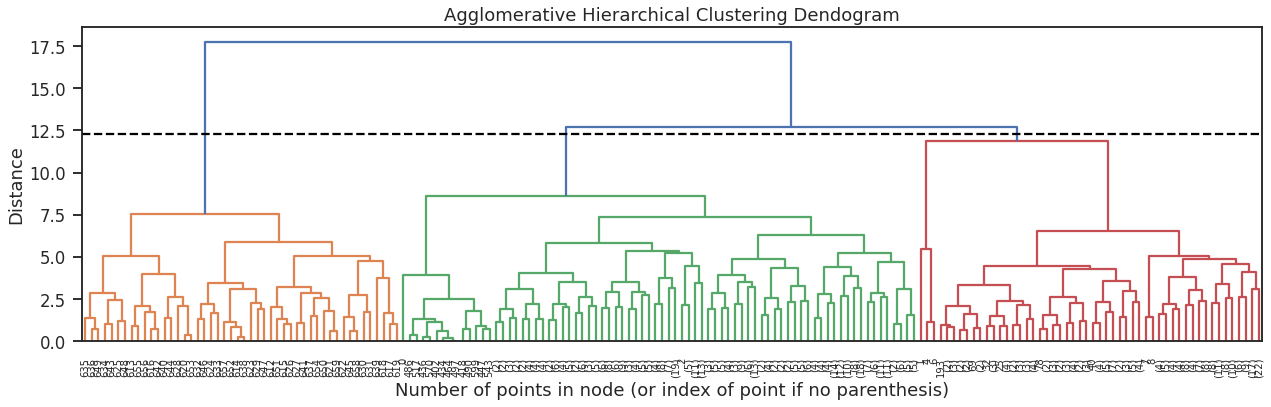

In [55]:
# Final Dendrogram Option for Hierarchical Clustering (Manhatan Distance Metric & Complete Linkage )
sns.set({'figure.figsize': (18, 6)})
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("talk")
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation = 90, p = 8, leaf_font_size = 10, truncate_mode = 'level')
plt.axhline(y = 12.3, color = "black", linestyle = '--')
plt.tight_layout()
plt.xlabel("Number of points in node (or index of point if no parenthesis)");

In [56]:
# Defining 03 clusters for subsequent analysis
HCmodel = AgglomerativeClustering(n_clusters = 3, affinity = 'cityblock', linkage = 'complete', compute_distances = True)
HCmodel.fit(data_std)

AgglomerativeClustering(affinity='cityblock', compute_distances=True,
                        linkage='complete', n_clusters=3)

In [57]:
# Appending the respective hierarchical clusters for each data row to the original dataset 
data['Hierarchical Cluster'] = HCmodel.labels_
data.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K-means Cluster,Hierarchical Cluster
0,100000,2,1,1,0,2,2
1,50000,3,0,10,9,0,0
2,50000,7,1,3,4,2,2
3,30000,5,1,1,4,2,2
4,100000,6,0,12,3,1,0
5,20000,3,0,1,8,0,0
6,100000,5,0,11,2,1,0
7,15000,3,0,1,1,0,0
8,5000,2,0,2,2,0,0
9,3000,4,0,1,7,0,0


In [58]:
# Creating insights about the Customer profile by grouping the original dataset by cluster
# Adding the counts and percentages for each segment in the grouped data table

cluster_profile_hierarchical = data.drop(columns = ['K-means Cluster']).groupby('Hierarchical Cluster').mean()
cluster_profile_hierarchical['Number of Entries in each Segment'] = data.groupby('Hierarchical Cluster')['Avg_Credit_Limit'].count()
cluster_profile_hierarchical['% in each Segment'] = round(100 * data.groupby('Hierarchical Cluster')['Avg_Credit_Limit'].count() / len(data), 1).astype(str) + '%'

In [59]:
# Displaying Cluster profile
cluster_profile_hierarchical.style.highlight_min(color = 'red', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Number of Entries in each Segment,% in each Segment
Hierarchical Cluster,,,,,,,
0,12977.777778,2.431111,0.920000,3.631111,6.844444,225,34.1%
1,142750.000000,8.875000,0.625000,10.875000,1.020833,48,7.3%
2,33713.178295,5.511628,3.485788,0.984496,2.005168,387,58.6%


- Looking at the table above, the first cluster (Hierarchical Cluster = 0) represents around 34% of the data entries takes the Customers with the lowest "Avg_Credit_Limit" and "Total_Credit_Cards", but with the highest "Total_calls_made".
- The second cluster (Hierarchical Cluster = 1) represents around 7% of the data entries takes the Customers with higher "Avg_Credit_Limit", "Total_Credit_Cards" and "Total_visits_online". It also encompasses the Customers who are not likely to go to the bank (lowest "Total_visits_bank"), and also less inclined to make calls to the bank (lowest "Total_calls_made").
- The third cluster (Hierarchical Cluster = 2) represents around 59% of the data entries is related to Customers who normally go to the bank (highest "Total_visits_bank"), and are not likely to use the online bank services (lowest "Total_visits_online").

***
## 6. Compare K-means and Hierarchical Clustering, Perform Cluster Profiling and Derive Insights <a class="anchor" id="666"></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:blue;">
    
- Compare Clusters obtained from K-means and Hierarchical Clustering Techniques
- Perform Cluster Profiling
- Insights about Different Clusters

### 6.1 - Compare Clusters Obtained from K-means and Hierarchical Clustering Techniques & Perform Cluster Profiling

In [60]:
# Displaying Cluster profile for K-means Clustering Approach
cluster_profile_Kmeans.style.highlight_min(color = 'red', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Number of Entries in each Segment,% in each Segment
K-means Cluster,,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224,33.9%
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50,7.6%
2,33782.383420,5.515544,3.489637,0.981865,2.000000,386,58.5%


In [61]:
# Displaying Cluster profile for Hierarchical Clustering Approach
cluster_profile_hierarchical.style.highlight_min(color = 'red', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Number of Entries in each Segment,% in each Segment
Hierarchical Cluster,,,,,,,
0,12977.777778,2.431111,0.920000,3.631111,6.844444,225,34.1%
1,142750.000000,8.875000,0.625000,10.875000,1.020833,48,7.3%
2,33713.178295,5.511628,3.485788,0.984496,2.005168,387,58.6%


- Both K-means and Hierarchical clustering approaches returned very similar results in terms of Customer Profiling/Segmentation.
- Looking at the tables above, the first cluster (either K-means Cluster or Hierarchical Cluster = 0) represents around 34% of the data entries and takes the Customers with the lowest "Avg_Credit_Limit" and "Total_Credit_Cards", but with the highest "Total_calls_made".
- The second cluster (either K-means Cluster or Hierarchical Cluster = 1) represents around 7-8% of the data entries and takes the Customers with higher "Avg_Credit_Limit", "Total_Credit_Cards" and "Total_visits_online". It also encompasses the Customers who are not likely to go to the bank (lowest "Total_visits_bank"), and also less inclined to make calls to the bank (lowest "Total_calls_made").
- The third cluster (either K-means Cluster or Hierarchical Cluster = 2) represents around 59% of the data entries and is related to Customers who normally go to the bank (highest "Total_visits_bank"), and are not likely to use the online bank services (lowest "Total_visits_online").

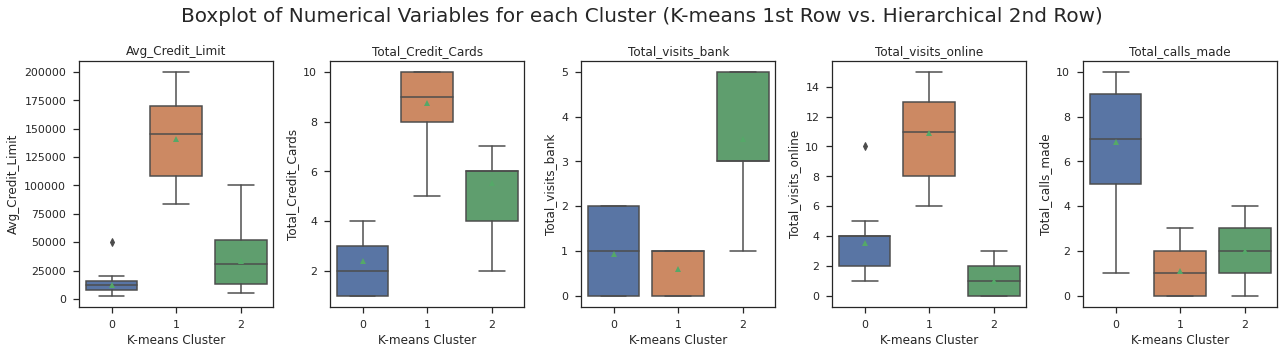

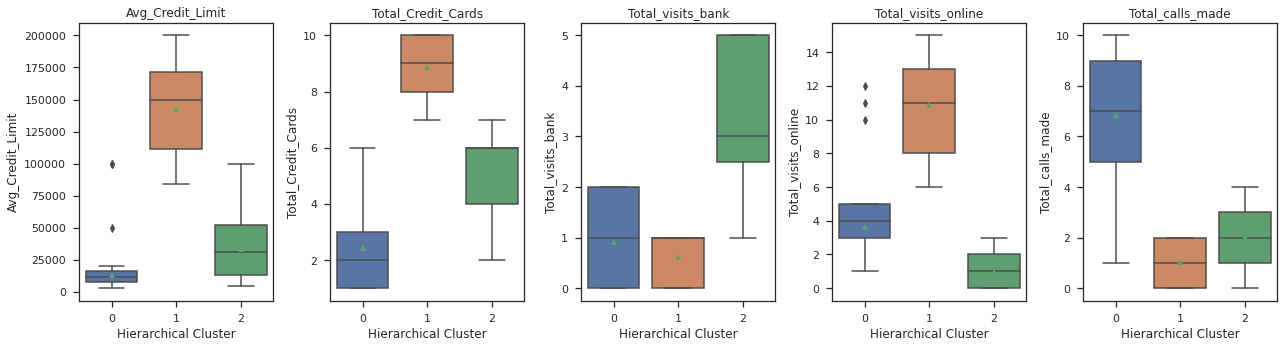

In [62]:
# Boxplots from the original dataset (not scaled) including the defined clusters at both approaches (K-means and Hierarchical)

features = data.drop(['K-means Cluster', 'Hierarchical Cluster'], axis = 1).columns.tolist()

sns.set({'figure.figsize': (18, 5)})
plt.suptitle('Boxplot of Numerical Variables for each Cluster (K-means 1st Row vs. Hierarchical 2nd Row)', fontsize = 20)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("notebook")

# Boxplots for K-means Clustering
for i, variable in enumerate(features):
    plt.subplot(1, 5, i + 1)
    sns.boxplot(x = 'K-means Cluster', y = data[variable], data = data, showfliers = True, showmeans = True)
    plt.tight_layout()
    plt.title(variable)
plt.show()

# Boxplots for Hierarchical Clustering
for i, variable in enumerate(features):
    plt.subplot(1, 5, i + 1)
    sns.boxplot(x = 'Hierarchical Cluster', y = data[variable], data = data, showfliers = True, showmeans = True)
    plt.tight_layout()
    plt.title(variable);

### 6.2 - Insights about Different Clusters

- **Cluster 0 - Low Credit Limit & Few Credit Cards Ownership & Phone Users**:
    - This cluster is related to Customers who have the lowest average credit limit (average between \\$12000 - $13000) and the lowest number of credit cards (average of around 2.4 cards) with the bank.
    - The Customers in this cluster are more inclined to make more calls to the bank (average between 6.8 - 6.9 calls).
    
   
- **Cluster 1 - High Credit Limit & Several Credit Cards Ownership & Online Users**:
    - This cluster is related to Customers who have both the highest average credit limit (average between \\$141000 - $143000) and the highest number of credit cards (average between 8.7 - 8.9 cards) with the bank.
    - The Customers in this cluster are less inclined to go to the bank for a visit (average of around 0.6 visit), and also less likely to call the bank (average between 1.0 - 1.1 calls). However, they are very inclined to use the bank online services (average of around 10.9 online visits).
    
    
- **Cluster 2 - Intermediate Credit Limit & Intermediate Number of Credit Cards Ownership & In-person Visitors**:
    - This cluster takes the Customers who have intermediate average credit limit (average around \\$34000) and intermediate amount of credit cards (average of around 5.5 cards) with the bank.
    - The Customers in this cluster are more inclined to go in person to the bank for a visit (average of around 3.5 visits).
    - The Customers in this cluster are less likely to go online to use the bank services (average of around 1.0 online visit), and also less likely to make phone calls to the bank (average of aorund 2.0 phone calls).

***
## 7. Actionable Insights & Recommendations <a class="anchor" id="777"></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:blue;">
    
- Conclude with the Key Takeaways for the Business
- What would your Business Recommendation.

### 7.1 - Key Takeaways and Business Recommendations

Problem Statement & Background:\
Currently, following the advise from their Marketing Research Department, the Alllife Bank Operations Team is aware that the penetration in the market can be improved, and that their Customers perceive the support services of the back poorly. Based on this, the Operations Team wants to upgrade the bank Service Delivery Model, to ensure the Customers queries are resolved faster.
- The main takeaway from the problem statement is that the bank needs to improve the penetration in the market and to ensure the Customers queries are resolved in a more efficient and effective manner. 02 variables in the dataset are associated with the penetration in the market or key products offered by the back to the Customers (credit limit and amount of credit cards). The different ways of interacting with the Customer are represented by the other 03 variables present in the dataset (in-person visits, online access and phone users).

Objective:\
To identify different segments based on existing Customer spending patterns as well as past interaction with the bank. Use the information extracted from these patterns to run personalised campaigns to target new Customers as well as upsell to existing Customers.
- Based on the objective above and leveraging the Customer Segmentation analysis outcomes, the 03 different segments can be used to support any personalized campaigns targetting existing and new Customers.

Key Questions:\
How many different segments of customers are there?
- As per the EDA, K-means (Centroid-based) and Hierarchical Cluster analysis, it was concluded that there are 03 different clusters associated with 03 different Customer segmentations.
        
How are these segments different from each other?
- Low Credit Limit & Few Credit Cards Ownership & Phone Users
- High Credit Limit & Several Credit Cards Ownership & Online Users
- Intermediate Credit Limit & Intermediate Number of Credit Cards Ownership & In-person Visitors

What are your recommendations to the bank on how to better market to and service these customers?
- Low Credit Limit & Few Credit Cards Ownership & Phone Users:
    > This cluster represents the Costumers who prefer to speak with an individual by phone when they have an issue, probably to connect with the bank in a more personal and flexible way, and to build more confidence on the offered bank services. For this Customer segment, the marketing campaigns can be more focused on not only providing excellence on resolving the Customer queries in a more efficient way over the phone, but also proactively calling the Customers to anticipate any possible queries they might have - that would potentially enhance the relationship with the Customers and open the door to offer additional credit limit and/or other credit card options. Around 34% of the Customers belong to this segment, and they could be targeted as an upselling opportunity to the bank since these Customers currently have lower credit limit and fewer credit cards.
    
- High Credit Limit & Several Credit Cards Ownership & Online Users
    > The Customers for this segment normally access the bank services by using online capabilities, probably because they have limited time and prefer to count on electronic transactions for a sake of speed, flexibility and convenience. These Customers represent around 7-8% of the total bank clients and might be business owners or executives with low probablity of defaulting with the bank since they have very high credit limits and several credit cards. For this segment, a marketing compaign could be more focused on digital transformation and more premium products offered by the bank - this could reinforce the relationship between the bank and the existing Customers, and also potentially attract new Customers to this profitable and premium segment. 
    
- Intermediate Credit Limit & Intermediate Number of Credit Cards Ownership & In-person Visitors
    > This is biggest segment at the bank, representing around 59% of the total bank clients. The Customers in this segment have an intermediate average credit limit (average around \\$34000) and an intermediate amount of credit cards (average of around 5.5 cards) with the bank. These Customers prefer to go in-person at the bank branches to get support when problems arise. A marketing compaign more focused in specific services which would require in-branch interactions (for instance, advices on rates and specific product offerings etc) could be develop for this segment. Connecting with Costumers in a personal way and timely addressing their queries or complaints may significantly improve their loyalty and attract new Customers to the bank.
    
- A very important detail that's recommended to be part of any future campaigns would be to capture the impact/results from all the actions included in the campaigns and perform a dynamic cluster analysis. The 'Customer Key' can be utilized to relate to same Customers and to keep track how Customers could be moving from one cluster to another. Also, any increase in the number of Customer keys over time (for a given timeframe) could also indicate whether the bank is attracting more Customers.